# IT3212 - Assignment 2

### Importing libraries

In [311]:
# Standard libraries
import numpy as np
import pandas as pd
import re
import string

# NLTK tools and datasets
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment if you need to download NLTK data packages
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Text processing
from textblob import TextBlob
import contractions

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from sklearn.model_selection import cross_val_predict

# Miscellaneous
from collections import Counter
from urllib.parse import unquote
from scipy import stats
import chardet


### Fix dataset encoding issues

In [312]:
# Some rows in the raw data include non UTF-8 characters. 

# Example of text with non UTF-8 characters:
# 778245336,FALSE,finalized,5,8/30/15 13:27,Not Relevant,0.7952,,army,
# text column: Pakistan,".: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo Indian Army ki��_ http://t.co/WJLJq3yA4g"
# ,6.29079E+17,195397186

# Chardet identifies the encoding of the raw data as 'MacRoman'.
# For now, we will remove all non UTF-8 characters from the raw data
# We handle this by removing all � characters from the raw data and writing the modified content back to the file.

def fix_non_utf8_encoding(filepath, destination_filepath):
    with open(filepath, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        print(result['encoding'])


    # Open the file in read mode, read its contents, then close it
    with open('data/disaster-tweets.csv', 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Remove all � characters
    content = content.replace('�', '')

    # Open the file in write mode and write the modified content back to it
    with open(destination_filepath, 'w', encoding='utf-8') as file:
        file.write(content)

filepath = 'data/disaster-tweets.csv'
dest = 'data/disaster-tweets-utf8.csv'

# fix_non_utf8_encoding(filepath, dest)

In [313]:
def split_train_test(filepath, destination_filepath_train, destination_filepath_test):
    df = pd.read_csv(filepath, encoding='utf-8')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    train_data.to_csv(destination_filepath_train, index=False)
    test_data.to_csv(destination_filepath_test, index=False)

filepath = 'data/disaster-tweets-utf8.csv'
dest_train = 'data/train.csv'
dest_test = 'data/test.csv'

# split_train_test(filepath, dest_train, dest_test)

### Importing dataset

In [314]:
df = pd.read_csv('./data/train.csv', encoding='utf-8')
df_test = pd.read_csv('./data/test.csv', encoding='utf-8')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07


##  Exploratory data analysis (EDA)

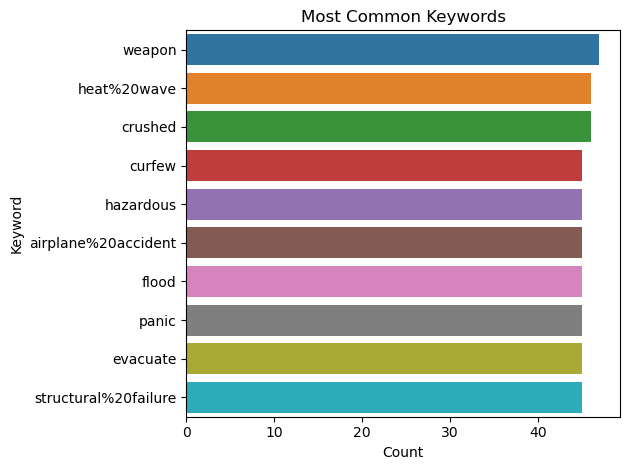

In [315]:
# Clean `keyword` column.

# Write the updated dataframe to a new CSV file
# Plot the most common keywords
defined_keywords = df[df['keyword'] != '']['keyword']

plt.figure()
sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
plt.title('Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.show()





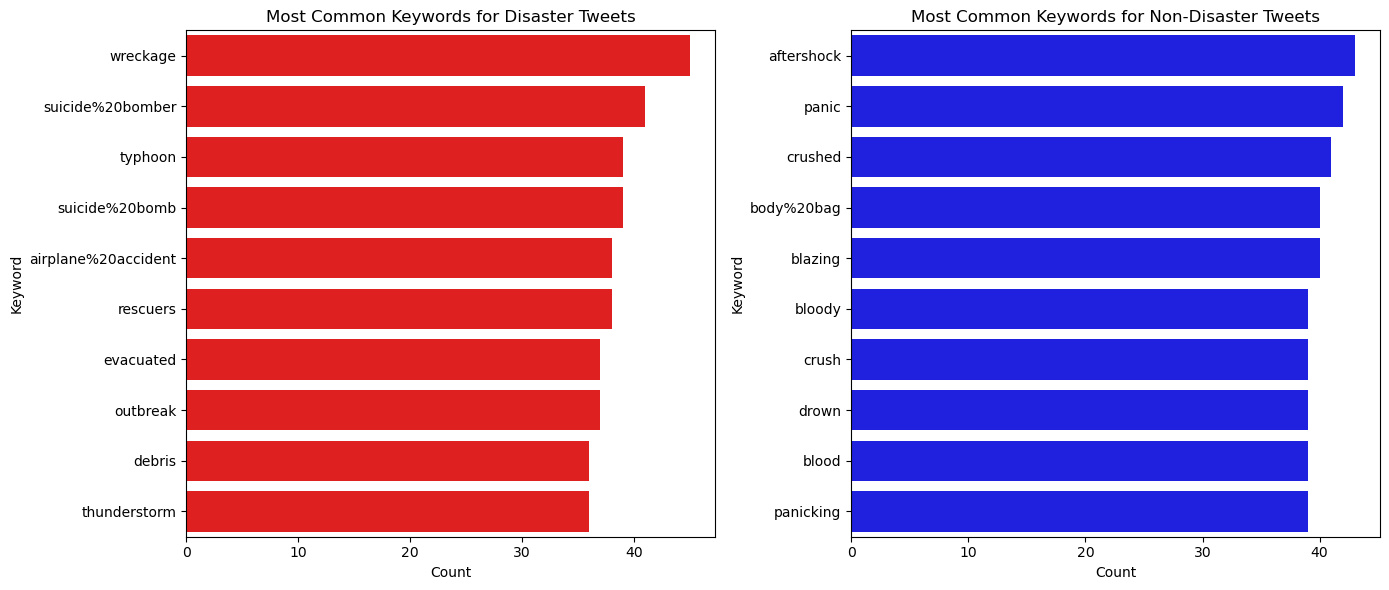

In [316]:
# Compare keywords for disaster tweets and non-disaster tweets
disaster_keywords = df[df['choose_one'] == 'Relevant']['keyword']
non_disaster_keywords = df[df['choose_one'] == 'Not Relevant']['keyword']

# Create a figure object and define the grid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting
sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

# Titles and labels
ax[0].set_title('Most Common Keywords for Disaster Tweets')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Keyword')

ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.show()



In the plot above, we can see that the top 10 shared keywords of disaster-related tweets and non-disaster-related tweets do not share any common keywords.

In [317]:

# sns.countplot(x='choose_one', data=df)
# plt.title('Number of Tweets with Target Value of 1 and 0') 


## 1. Preprocessing

In [318]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def filter_rows_by_confidence_and_decision(df, confidence_threshold):
    df = df[df['choose_one:confidence'] >= confidence_threshold]
    df = df[df['choose_one'] != "Can't Decide"]
    return df

def map_choose_one_to_y(df):
    df['target'] = df['choose_one'].apply(lambda choice: 1 if choice == 'Relevant' else 0)
    return df

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = contractions.fix(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

def clean_keyword(keyword):
    return unquote(keyword) if pd.notnull(keyword) else ''

def clean_data(df):
    df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)
    df['text_raw'] = df['text']
    df['text'] = df['text'].apply(clean_text)
    return df

initial_count = df.shape[0]
confidence_threshold = 0.7

df = filter_rows_by_confidence_and_decision(df, confidence_threshold)
print("Removed {} of total: {} rows. Remaining rows: {}".format(initial_count - df.shape[0], initial_count, df.shape[0]))

features_to_keep = ['target', 'text', 'keyword']

df = map_choose_one_to_y(df)
df = df[features_to_keep]
df = clean_data(df)

count_initial = df.shape[0]
df = df.drop_duplicates(subset=['text'])
print("Removed {} duplicated rows.".format(count_initial - df.shape[0]))


# Preprocess the test data as well
df_test = map_choose_one_to_y(df_test)
df_test = df_test[features_to_keep]
df_test = clean_data(df_test)

df_test.head()


Removed 2167 of total: 8700 rows. Remaining rows: 6533
Removed 638 duplicated rows.


,target,text,keyword,text_raw
0,1,sunset looked like erupting volcano initial th...,volcano,The sunset looked like an erupting volcano ......
1,1,7294 nikon d50 61 mp digital slr camera body 2...,body bag,#7294 Nikon D50 6.1 MP Digital SLR Camera Body...
2,0,mentaltwitter note make sure smoke alarm batte...,smoke,Mental/Twitter Note: Make sure my smoke alarm ...
3,0,emergency need part 2 3 nashnewvideo nashgrier...,emergency,?????? EMERGENCY ?????? NEED PART 2 and 3!!! #...
4,0,whelen model 295ss100 siren amplifier police e...,siren,WHELEN MODEL 295SS-100 SIREN AMPLIFIER POLICE ...


## 2. Extracting features

### Features that can be extracted from the raw text

In [319]:
def extract_features(df): 
    # Create new column for text length
    df['text_length'] = df['text_raw'].apply(len)
    # Extract the number of hashtags
    df["hashtag_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "#"]))

    # Extract the number of mentions
    df["mention_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "@"]))

    # Extract the `has_url` feature
    df["has_url"] = df["text_raw"].apply(lambda x: 1 if "http" in str(x) else 0)
    return df

# Write the updated dataframe to a CSV file
df = extract_features(df)
df_test = extract_features(df_test)
df.head()

,target,text,keyword,text_raw,text_length,hashtag_count,mention_count,has_url
0,0,do not even remember slsp happening remember l...,screamed,i dont even remember slsp happening i just rem...,134,0,0,0
1,0,hazelannmac ooh feel guilty wishing hatman bet...,mudslide,@hazelannmac ooh now I feel guilty about wishi...,94,0,1,0
2,0,soultech collide club mix,collide,Soultech - Collide (Club Mix) http://t.co/8xIx...,52,0,0,1
3,1,police officer wounded suspect dead exchanging...,wounded,Police Officer Wounded Suspect Dead After Exch...,83,0,0,1
4,0,cramer igers 3 word wrecked disney stock,wrecked,Cramer: Iger's 3 words that wrecked Disney's s...,73,0,0,1


#### Analysis of new features

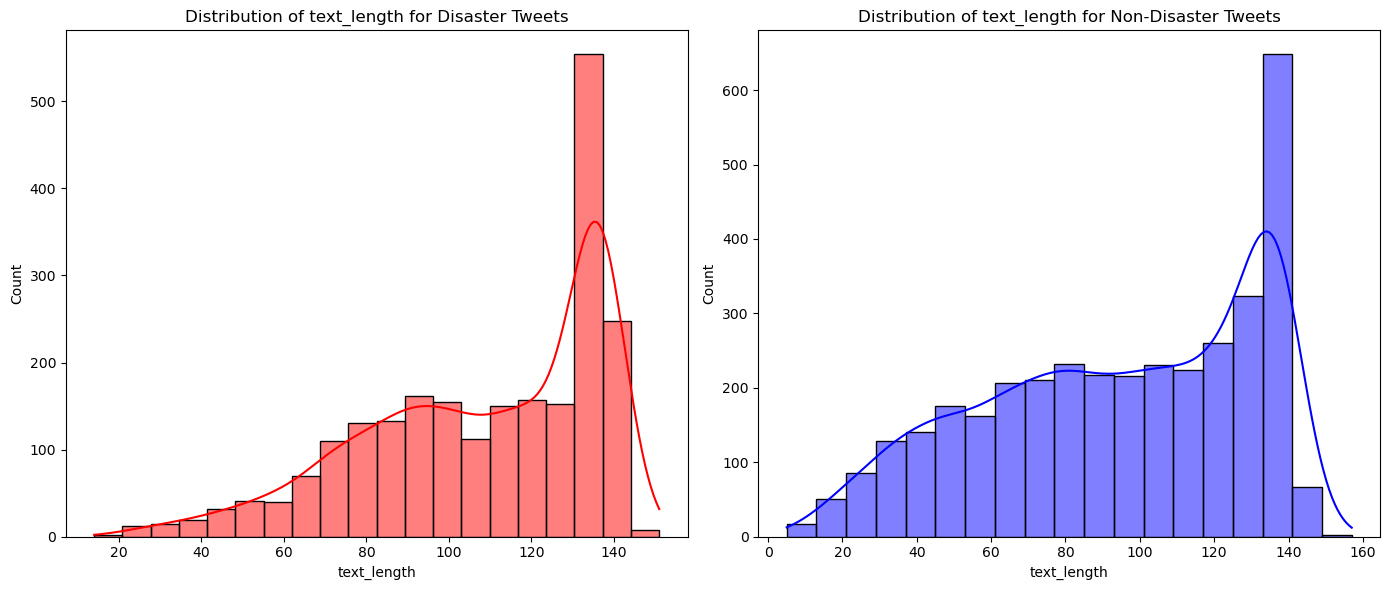

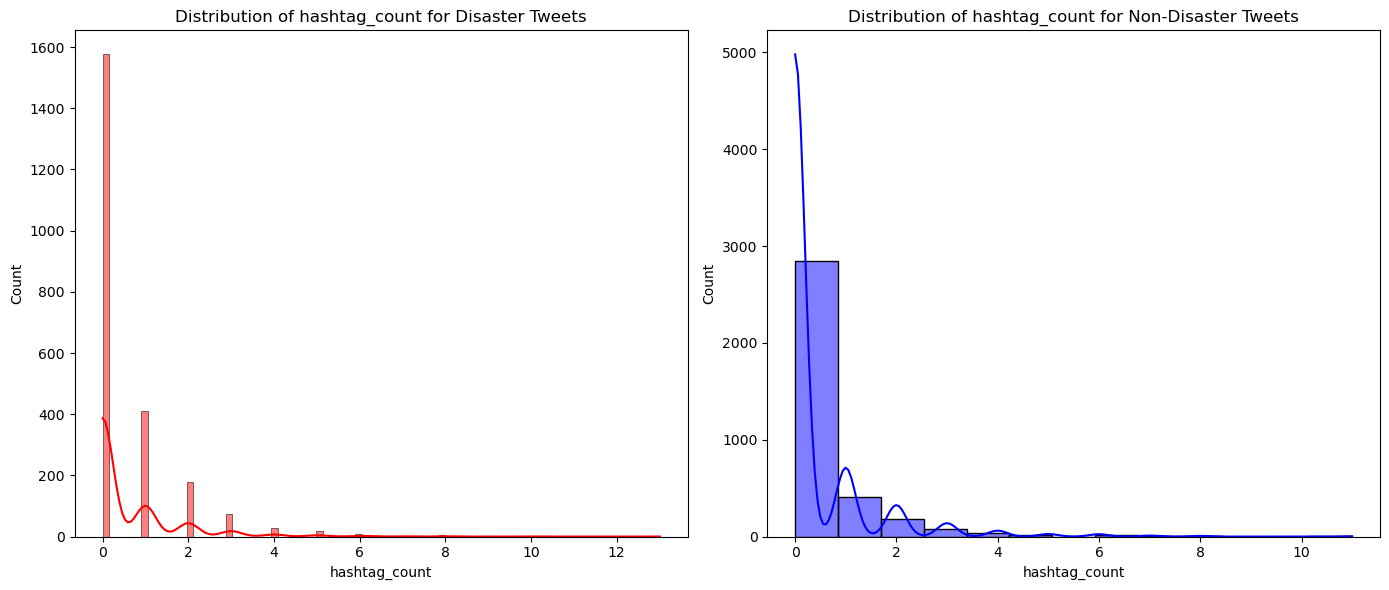

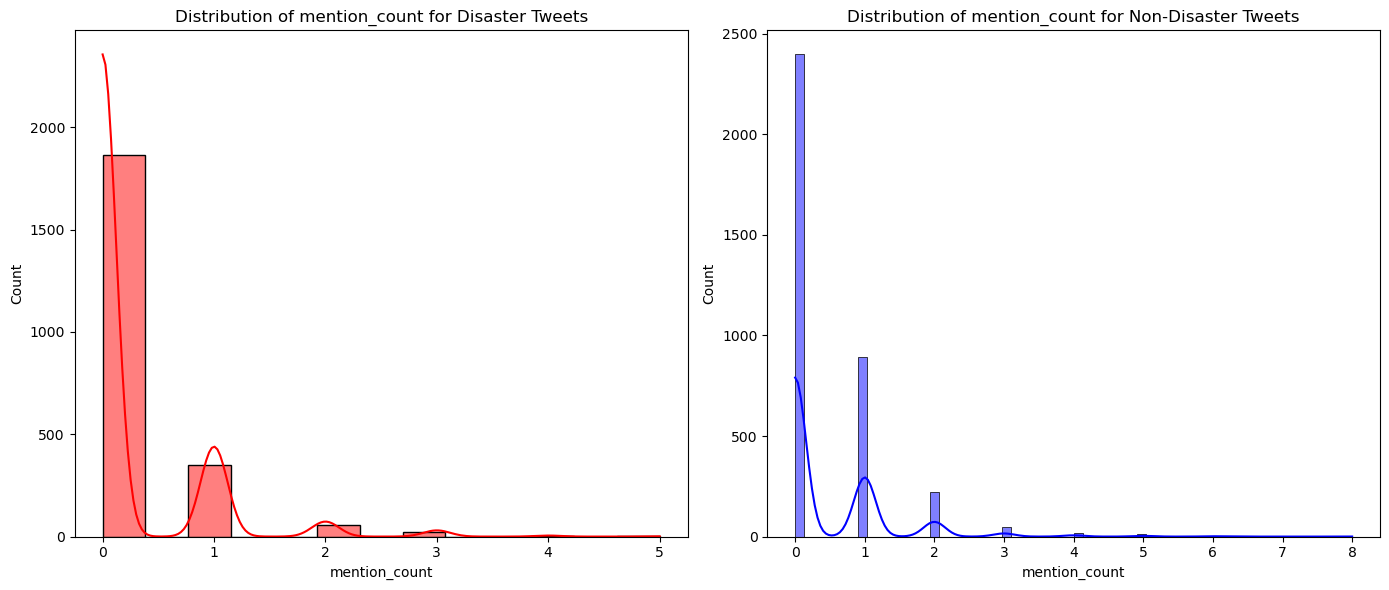

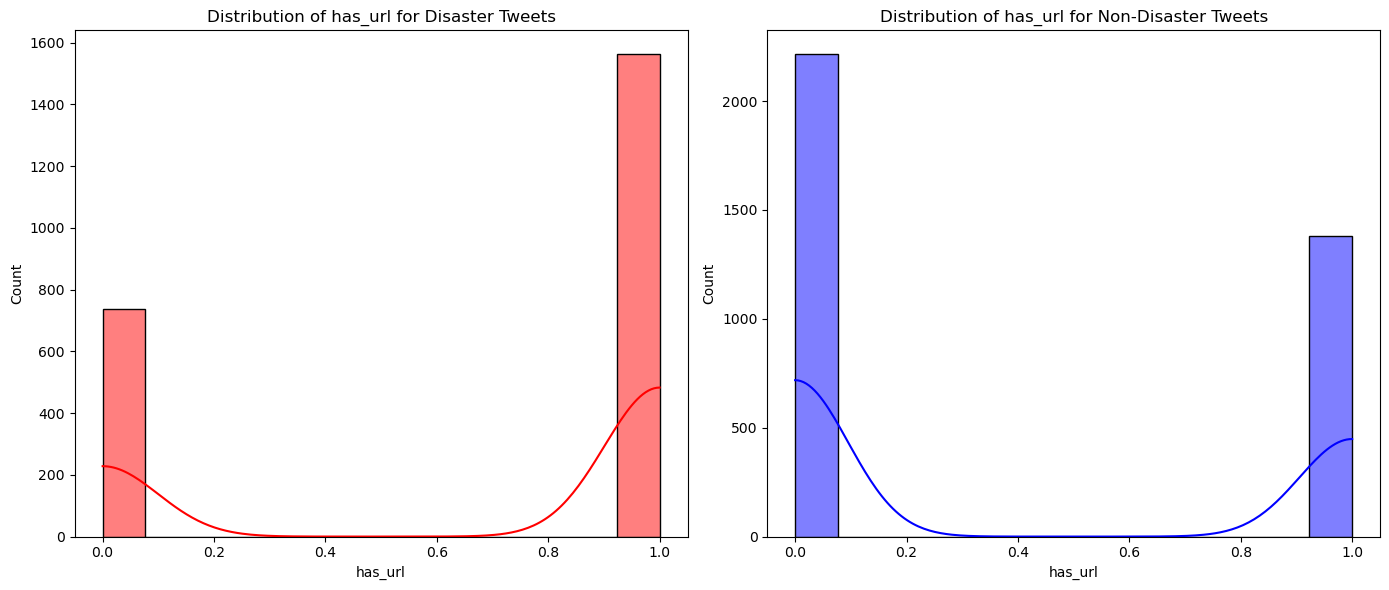

In [320]:
# df['text_length'] = df['text_raw'].apply(len)
#     # Extract the number of hashtags
#     df["hashtag_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "#"]))

#     # Extract the number of mentions
#     df["mention_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "@"]))

#     # Extract the `has_url` feature
#     df["has_url"] = df["text_raw"].apply(lambd
# Create a figure object and define the grid
def plot_distribution_difference(feature):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plotting using histplot instead of distplot
    sns.histplot(df[df['target'] == 1][feature], ax=ax[0], color='red', kde=True)  # kde=True will add a curve to the histogram
    sns.histplot(df[df['target'] == 0][feature], ax=ax[1], color='blue', kde=True)

    # Titles and labels
    ax[0].set_title('Distribution of {} for Disaster Tweets'.format(feature))
    ax[0].set_xlabel(feature)

    ax[1].set_title('Distribution of {} for Non-Disaster Tweets'.format(feature))
    ax[1].set_xlabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

features = ['text_length', 'hashtag_count', 'mention_count', 'has_url']
for feature in features:
    plot_distribution_difference(feature)



### Sentiment analysis


In [321]:
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']

df['sentiment'] = df['text'].apply(analyze_sentiment_vader)
df_test['sentiment'] = df_test['text'].apply(analyze_sentiment_vader)

df.sentiment.head()

0   -0.5574
1    0.4215
2   -0.0772
3   -0.7579
4    0.0000
Name: sentiment, dtype: float64

#### Checking if sentiment and target is correlated


In [322]:
disaster_group = df[df['target'] == 1]['sentiment']
not_disaster_group = df[df['target'] == 0]['sentiment']

t_statistic, p_value = stats.ttest_ind(disaster_group, not_disaster_group, equal_var=False)

p_value, t_statistic

(3.520081770393815e-102, -21.96539979122823)

The t-statistic measures the size of the difference relative to the variation in the data. A larger absolute value of the t-statistic means that the difference is more significant. Since it's negative, this indicates that the mean sentiment score of the disaster_group is lower than the mean sentiment score of the not_disaster_group.

The p-value is extremely small. In general terms, when the p-value is near 0, it suggests that the observed data is very unlikely under the null hypothesis. The null hypothesis for this t-test is that the mean sentiment scores of the disaster and non-disaster tweets are the same.

### Ngrams

In [323]:
def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams


df['bigrams'] = df['text'].apply(lambda x: create_ngrams(x, 2))
df['trigrams'] = df['text'].apply(lambda x: create_ngrams(x, 3))

df_test['bigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 2))
df_test['trigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 3))

In [324]:
def create_ngrams_string(ngram_list):
    ngram_words = ['_'.join(ngram) for ngram in ngram_list]
    ngram_string = ' '.join(ngram_words)
    return ngram_string
# Sample trigrams and bigrams data

df_temp = df.copy()

df_temp['bigrams'] = df['bigrams'].apply(lambda x: create_ngrams_string(x))
df_temp['trigrams'] = df['trigrams'].apply(lambda x: create_ngrams_string(x))

df['text_with_ngrams'] = df['text'] + ' ' +  df_temp['bigrams'] + ' ' + df_temp['trigrams'] 



#### Explore ngrams

In [325]:

disaster_bigrams = df[df['target'] == 1]['bigrams']
non_disaster_bigrams = df[df['target'] == 0]['bigrams']

disaster_bigram_counts = Counter([gram for ngram_list in disaster_bigrams for gram in ngram_list])
non_disaster_bigram_counts = Counter([gram for ngram_list in non_disaster_bigrams for gram in ngram_list])

print("Most common n-grams in disaster-related tweets:")
print(disaster_bigram_counts.most_common(10))


print("\nMost common n-grams in non-disaster tweets:")
print(non_disaster_bigram_counts.most_common(10))

disaster_trigrams = df[df['target'] == 1]['trigrams']
non_disaster_trigrams = df[df['target'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))


print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common n-grams in disaster-related tweets:
[(('suicide', 'bomber'), 47), (('do', 'not'), 34), (('i', 'am'), 33), (('severe', 'thunderstorm'), 32), (('suicide', 'bombing'), 28), (('wild', 'fire'), 28), (('thunderstorm', 'warning'), 26), (('heat', 'wave'), 25), (('northern', 'california'), 24), (('70', 'year'), 22)]

Most common n-grams in non-disaster tweets:
[(('i', 'am'), 230), (('do', 'not'), 126), (('can', 'not'), 77), (('you', 'are'), 74), (('going', 'to'), 41), (('youtube', 'video'), 30), (('i', 'have'), 30), (('that', 'is'), 30), (('liked', 'youtube'), 29), (('look', 'like'), 28)]
Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14), (('16yr', 'old', 'pkk'), 14), (('old', 'pkk', 'suicide'), 14), ((

In [326]:
disaster_trigrams = df[df['target'] == 1]['trigrams']
non_disaster_trigrams = df[df['target'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))


print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14), (('16yr', 'old', 'pkk'), 14), (('old', 'pkk', 'suicide'), 14), (('detonated', 'bomb', 'turkey'), 14)]

Most common trigrams in non-disaster tweets:
[(('liked', 'youtube', 'video'), 29), (('i', 'am', 'going'), 20), (('pick', 'fan', 'army'), 16), (('likely', 'rise', 'top'), 14), (('rise', 'top', 'pay'), 14), (('top', 'pay', 'pile'), 14), (('do', 'not', 'know'), 13), (('ignition', 'knock', 'detonation'), 12), (('cross', 'body', 'bag'), 12), (('deluged', 'invoice', 'make'), 11)]


### Keyword feature

In [327]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

keyword_embedded = vectorizer.fit_transform(df['keyword'])
keyword_embedded_df = pd.DataFrame(keyword_embedded.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

keyword_embedded_test = vectorizer.transform(df_test['keyword'])
keyword_embedded_test_df = pd.DataFrame(keyword_embedded_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

<Axes: >

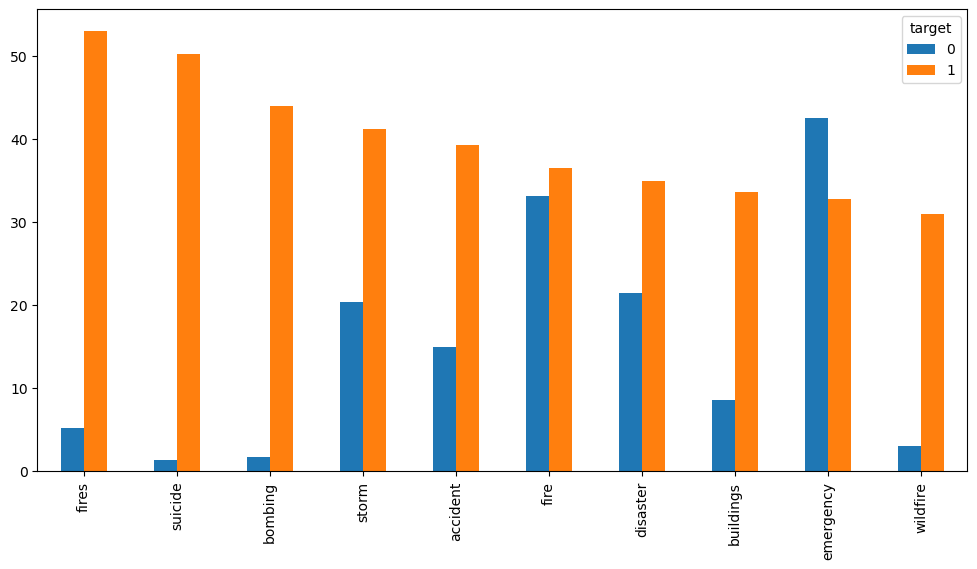

In [328]:
# Bar chart of keywords with the highest number of accidents
keyword_embedded_df['target'] = df['target']
keyword_embedded_df.groupby('target').sum().T.sort_values(1, ascending=False).head(10).plot(kind='bar', figsize=(12, 6))

### Text feature - encoding using TF-IDF

In [329]:
vectorizer = TfidfVectorizer(max_features=1000)

feature_to_embed = 'text_with_ngrams'

# Fit and transform the training data
text_embedded = vectorizer.fit_transform(df[feature_to_embed])
text_embedded_df = pd.DataFrame(text_embedded.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

# Transform the test data using the same vectorizer
text_embedded_test = vectorizer.transform(df_test[feature_to_embed])
text_embedded_test_df = pd.DataFrame(text_embedded_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)



KeyError: 'text_with_ngrams'

In [ ]:
df.columns

Index(['target', 'text', 'keyword', 'text_raw', 'text_length', 'hashtag_count',
       'mention_count', 'has_url', 'bigrams', 'trigrams', 'text_with_ngrams'],
      dtype='object')

## 3. Selecting features

In [ ]:
# storing this for later we can test different features without having to re-run cells above this one
df_checkpoint = df.copy()
df_test_checkpoint = df_test.copy()

In [ ]:
# Show current extracted features
df.columns

Index(['target', 'text', 'keyword', 'text_raw', 'text_length', 'hashtag_count',
       'mention_count', 'has_url', 'bigrams', 'trigrams', 'text_with_ngrams'],
      dtype='object')

In [ ]:
features_to_keep = ['has_url', 'sentiment']

df = df_checkpoint[features_to_keep]
df_test = df_test_checkpoint[features_to_keep]

# extract y_train and y_test here to avoid column name collision with 'target' feature coming from text and keyword embeddings
y_train = df['target']
y_test = df_test['target']

# Concatenate the dataframes with td-idf features for the text feature
df = pd.concat([df, text_embedded_df, keyword_embedded_df], axis=1)
df_test = pd.concat([df_test, text_embedded_test_df, keyword_embedded_test_df], axis=1)

X_train = df.drop(['target'], axis=1)
X_test = df_test.drop(['target'], axis=1)

## 4. Modelling

In [337]:
def print_results(y_pred, y_train, y_pred_test, y_test):
    print("Train results")
    print("-----------------------------")
    print("Train accuracy: {}".format(accuracy_score(y_train, y_pred)))
    print(classification_report(y_train, y_pred))
    print(confusion_matrix(y_train, y_pred))

    print()
    print("Test results")
    print("-----------------------------")
    print("Test accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))


### 4.1 Logistic regression

In [338]:
logreg = LogisticRegression(random_state=42, solver="liblinear")
logreg.fit(X_train, y_train)

y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)  # 5-fold cross-validation
y_pred_test = logreg.predict(X_test)

print_results(y_pred, y_train, y_pred_test, y_test)

Train results
-----------------------------
Train accuracy: 0.8497031382527566
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3595
           1       0.84      0.76      0.80      2300

    accuracy                           0.85      5895
   macro avg       0.85      0.83      0.84      5895
weighted avg       0.85      0.85      0.85      5895

[[3250  345]
 [ 541 1759]]

Test results
-----------------------------
Test accuracy: 0.7922794117647058
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1219
           1       0.81      0.69      0.75       957

    accuracy                           0.79      2176
   macro avg       0.80      0.78      0.79      2176
weighted avg       0.79      0.79      0.79      2176

[[1060  159]
 [ 293  664]]


In [339]:

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

print_results(y_pred, y_train, y_pred_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 2}
Train results
-----------------------------
Train accuracy: 0.9027989821882951
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3595
           1       0.91      0.84      0.87      2300

    accuracy                           0.90      5895
   macro avg       0.90      0.89      0.90      5895
weighted avg       0.90      0.90      0.90      5895

[[3393  202]
 [ 371 1929]]

Test results
-----------------------------
Test accuracy: 0.7954963235294118
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1219
           1       0.81      0.71      0.75       957

    accuracy                           0.80      2176
   macro avg       0.80      0.79      0.79      2176
weighted avg       0.80      0.80      0.79      2176

[[1056  163]
 [ 282  675]]


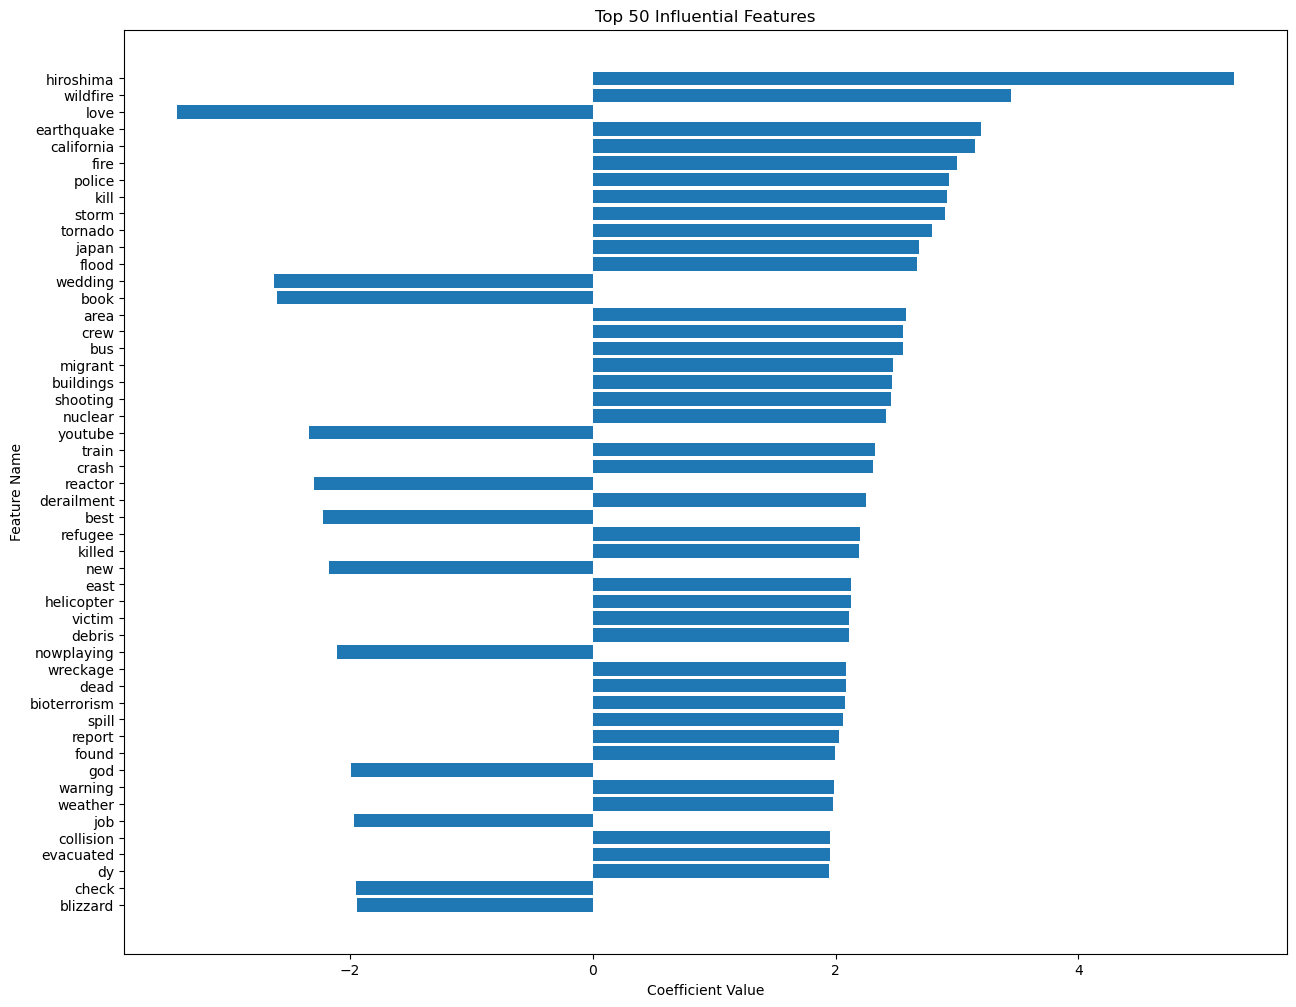

In [340]:
# visualize the features with the highest coefficients
# Get the feature names
feature_names = X_train.columns
# 1. Get the coefficients
coefs = grid_search.best_estimator_.coef_[0]

# 2. Rank them based on magnitude
sorted_indices = np.argsort(np.abs(coefs))[::-1][:50]  # sort by absolute value and take top 50

# 3. Visualize the top 50
plt.figure(figsize=(15, 12))
plt.barh(range(50), coefs[sorted_indices])
plt.yticks(range(50), feature_names[sorted_indices])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 50 Influential Features')
plt.gca().invert_yaxis()  # This is to have the most influential feature at the top
plt.show()

### 4.1.2. Support Vector Machines

In [345]:
first_n = 4000

# Initialize SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42, probability=False)

# Fit the model on training data
svm_model.fit(X_train[:first_n], y_train[:first_n])

# Predict on the rest of the training set
y_pred = svm_model.predict(X_train[first_n:])
y_pred_test = svm_model.predict(X_test[:first_n])

print_results(y_pred, y_train[first_n:], y_pred_test, y_test[:first_n])


# # Use 5-fold cross-validation to get predictions on training set
# y_pred_train = cross_val_predict(svm_model, X_train, y_train, cv=5)

# # Compute classification metrics on training set
# print(classification_report(y_train, y_pred_train))

# # Compute confusion matrix on training set
# print(confusion_matrix(y_train, y_pred_train))


Train results
-----------------------------
Train accuracy: 0.837467018469657
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1158
           1       0.82      0.75      0.78       737

    accuracy                           0.84      1895
   macro avg       0.83      0.82      0.83      1895
weighted avg       0.84      0.84      0.84      1895

[[1036  122]
 [ 186  551]]

Test results
-----------------------------
Test accuracy: 0.7909007352941176
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1219
           1       0.80      0.70      0.75       957

    accuracy                           0.79      2176
   macro avg       0.79      0.78      0.78      2176
weighted avg       0.79      0.79      0.79      2176

[[1053  166]
 [ 289  668]]
